<a href="https://colab.research.google.com/github/leedain0301/leedain0301-Data_Project_03/blob/main/NLP_Project_Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/labeledTrainData.tsv', delimiter='\t', quoting=3)
test = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/testData.tsv', delimiter='\t', quoting=3)

unlabeled_train = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/unlabeledTrainData.tsv', 
                              header=0, delimiter='\t', quoting=3)

print(train.shape)
print(test.shape)
print(unlabeled_train.shape)

print(train['review'].size)
print(test['review'].size)
print(unlabeled_train['review'].size)

(25000, 3)
(25000, 2)
(50000, 2)
25000
25000
50000


In [ ]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [ ]:
import re

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from multiprocessing import Pool

In [ ]:
def review_to_wordlist(review, remove_stopwords=False):
        review_text = BeautifulSoup(review, "html.parser").get_text()
        review_text = re.sub('[^a-zA-Z]', ' ', review_text)
        words = review_text.lower().split()
        if remove_stopwords:
            stops = set(stopwords.words('english'))
            words = [w for w in words if not w in stops]
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]
        return(words)

In [ ]:
def review_to_join_words( review, remove_stopwords=False ):
      words = review_to_wordlist(\
          review, remove_stopwords=False)
      # 불용어 유지
      join_words = ' '.join(words)
      return join_words

In [ ]:
def review_to_sentences( review, remove_stopwords=False ):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(\
                review_to_wordlist(\
                raw_sentence, remove_stopwords))
    return sentences

In [ ]:
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

In [ ]:
def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(result)

In [ ]:
review_to_wordlist(train['review'][0])[:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
sentences = []
for review in train["review"]:
    sentences += review_to_sentences(
        review, remove_stopwords=False)

In [ ]:
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(
        review, remove_stopwords=False)

In [ ]:
len(sentences)

794002

In [ ]:
sentences[0][:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [ ]:
sentences[4][:10]

['some', 'may', 'call', 'mj', 'an', 'egotist', 'for', 'consent', 'to', 'the']

In [ ]:
sentences[5][:10]

['whi', 'he', 'want', 'mj', 'dead', 'so', 'bad', 'is', 'beyond', 'me']

In [ ]:
sentences[6][:10]

['becaus', 'mj', 'overheard', 'his', 'plan']

In [ ]:
sentences[7][:10]

['nah', 'joe', 'pesci', 's', 'charact', 'rant', 'that', 'he', 'want', 'peopl']

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [ ]:
num_features = 300
min_word_count = 40 
num_workers = 4 
context = 10 
downsampling = 1e-3

from gensim.models import word2vec

model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

In [ ]:
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
model.save(model_name)

In [ ]:
model.wv.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [ ]:
model.wv.doesnt_match("france england germany berlin".split())

'berlin'

In [ ]:
model.wv.most_similar("man")

[('woman', 0.643549919128418),
 ('millionair', 0.5272088646888733),
 ('ladi', 0.5077311396598816),
 ('businessman', 0.5062713027000427),
 ('lad', 0.5012030601501465),
 ('farmer', 0.4746062159538269),
 ('policeman', 0.4664461016654968),
 ('loner', 0.4662756621837616),
 ('men', 0.46148011088371277),
 ('priest', 0.4425860047340393)]

In [ ]:
model.wv.most_similar("queen")

[('princess', 0.6178750395774841),
 ('latifah', 0.5705339312553406),
 ('regina', 0.5643806457519531),
 ('victoria', 0.5557170510292053),
 ('goddess', 0.553458571434021),
 ('anita', 0.5357435345649719),
 ('countess', 0.5340474843978882),
 ('seductress', 0.5325914621353149),
 ('maid', 0.5289620161056519),
 ('mistress', 0.525242030620575)]

In [ ]:
model.wv.most_similar("film")

[('movi', 0.856643557548523),
 ('flick', 0.6101890802383423),
 ('pictur', 0.5556603670120239),
 ('documentari', 0.5441884398460388),
 ('cinema', 0.506055474281311),
 ('it', 0.49722737073898315),
 ('masterpiec', 0.4899998903274536),
 ('genr', 0.4849259853363037),
 ('effort', 0.4733966290950775),
 ('sequel', 0.4594869613647461)]

In [ ]:
model.wv.most_similar("happi") 

[('unhappi', 0.4490591883659363),
 ('satisfi', 0.4166378378868103),
 ('sad', 0.40899547934532166),
 ('bitter', 0.4036322832107544),
 ('afraid', 0.38993608951568604),
 ('glad', 0.3765805959701538),
 ('proud', 0.36671167612075806),
 ('joy', 0.36606454849243164),
 ('comfort', 0.36387354135513306),
 ('upset', 0.35754674673080444)]

### Word2Vec으로 벡터화 한 단어를 t-SNE 를 통해 시각화

In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(X[:100,:])

11986
[ 0.00467708  0.07879636  0.08629572  0.0572859   0.02377285 -0.00144495
  0.07784202 -0.00238662 -0.05066631  0.08978955]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [ ]:
df.head(10)

,x,y
with,-6.767395,-0.936524
all,-2.954873,3.307956
this,-0.448278,2.152205
stuff,-1.976269,-2.315531
go,2.641775,-3.570008
down,-8.914538,-3.372394
at,-6.996994,-2.592021
the,-4.466446,3.702896
moment,-1.916742,7.656163
mj,-4.539456,-8.393744


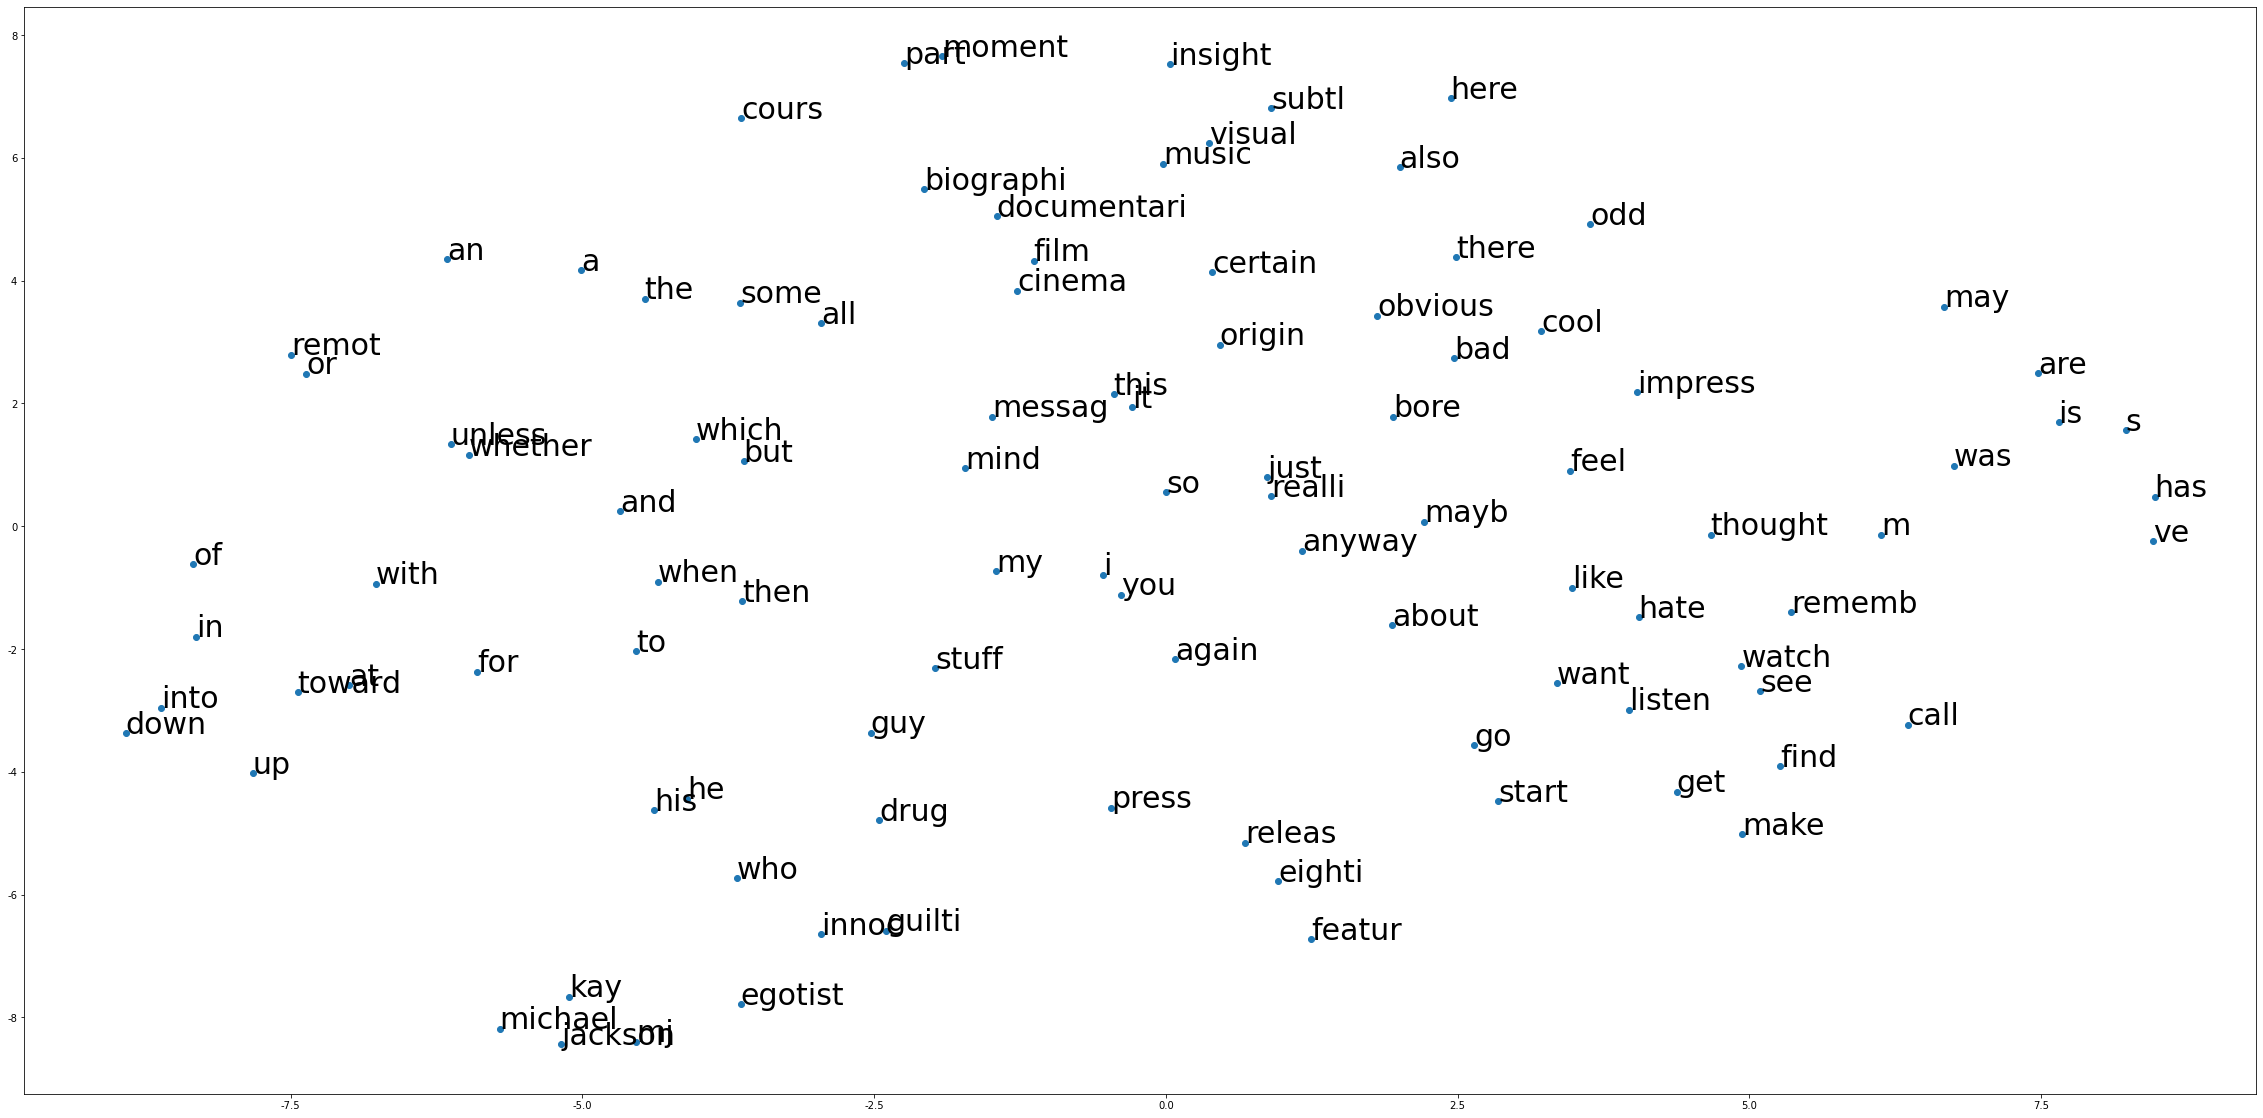

In [ ]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [ ]:
import numpy as np

def makeFeatureVec(words, model, num_features):

    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word)

    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
 
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [ ]:
def getAvgFeatureVecs(reviews, model, num_features):

    counter = 0.

    reviewFeatureVecs = np.zeros(
        (len(reviews),num_features),dtype="float32")
    
    for review in reviews:
        if counter%1000. == 0.:
            print("Review %d of %d" % (counter, len(reviews)))
        reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
        counter = counter + 1.
    return reviewFeatureVecs

In [ ]:
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = apply_by_multiprocessing(\
        reviews["review"], review_to_wordlist,\
        workers=4)
    return clean_reviews

In [ ]:
%time trainDataVecs = getAvgFeatureVecs(\
    getCleanReviews(train), model, num_features ) 

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 7s, sys: 1.46 s, total: 1min 9s
Wall time: 2min 40s


In [ ]:
%time testDataVecs = getAvgFeatureVecs(\
        getCleanReviews(test), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 6s, sys: 1.09 s, total: 1min 7s
Wall time: 2min 29s


In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

In [ ]:
%time forest = forest.fit( trainDataVecs, train["sentiment"] )

CPU times: user 1min 14s, sys: 140 ms, total: 1min 15s
Wall time: 47.1 s


In [ ]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, trainDataVecs, \
    train['sentiment'], cv=10, scoring='roc_auc'))

CPU times: user 8.35 s, sys: 1.36 s, total: 9.71 s
Wall time: 7min 13s


In [ ]:
score

0.9083336

In [ ]:
result = forest.predict( testDataVecs )

In [ ]:
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv('Word2Vec_AverageVectors_{0:.5f}.csv'.format(score), 
              index=False, quoting=3 )

* 300features_40minwords_10text 일 때 0.90709436799999987
* 300features_50minwords_20text 일 때 0.86815798399999999

In [ ]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

-130


1    12565
0    12435
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

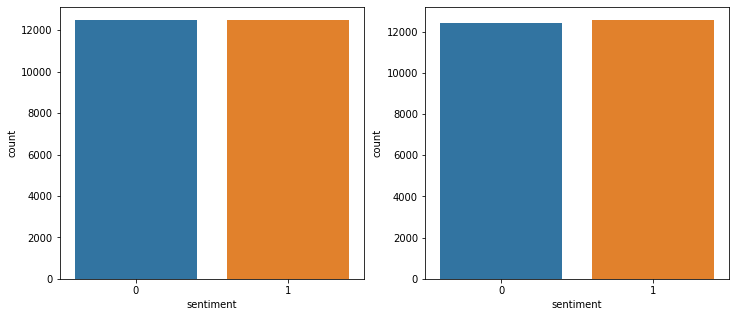

In [ ]:
import seaborn as sns 
%matplotlib inline

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [ ]:
544/578

0.9411764705882353